In [77]:
import time
import copy
import sys
from collections import OrderedDict
from collections import namedtuple
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import numpy as np
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import random 
import pickle
from collections import defaultdict
import math

In [78]:
#Configure GPU (change if not M1 mac)
mps = torch.device("mps")

In [79]:
# Datasets

# Using CIFAR-10 again as in the programming assignments
# Load training data
transform_train = transforms.Compose([                                   
    transforms.RandomCrop(32, padding=4),                                       
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, 
                                        download=True,
                                        transform=transform_train)

# Load testing data
transform_test = transforms.Compose([                                           
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True,
                                       transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [80]:
# Saving And helpers

def save_tracker(tracker, path):
  np.savetxt(path, tracker, delimiter=',') 

def save_trackers(device, filename):
  """Save all trackers and current total_time to a file."""
  torch.save((device['train_loss_tracker'], device['train_acc_tracker'], device['test_loss_tracker'], device['test_acc_tracker'], total_time), filename)
  print("Saved trackers to " + filename)

def moving_average(a, n=100):
  '''Helper function used for visualization'''
  ret = torch.cumsum(torch.Tensor(a), 0)
  ret[n:] = ret[n:] - ret[:-n]
  return ret[n - 1:] / n

# Plotting helpers! 
def make_plot(trackers, num_epochs, title, y_axis_lab, should_average=False, legend=True, fix_ax=True):
  avg_fn = moving_average if should_average else (lambda x : x) 
  x = np.arange(1, len(avg_fn(list(trackers.values())[0])) + 1)
  x = x / (len(x)/num_epochs)
  ax = plt.subplot(1,1,1)
  plt.title(title)
  plt.xlabel("Epoch")
  plt.ylabel(y_axis_lab)
  if fix_ax:
    ax.set_ylim([0, 100])
  # plt.xticks(np.arange(min(x), max(x)+1, 1))
  ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%1.0f'))

  for lab, t in trackers.items(): 
    l1, = ax.plot(x, avg_fn(t), label = lab)

  if legend:
    _ = plt.legend()
  plt.show()

def make_plot_better(trackers, num_epochs, title, y_axis_lab, should_average=False, n = 100):
  avg_fn = (lambda x : moving_average(x, n)) if should_average else (lambda x : x) 
  x = np.arange(1, len(avg_fn(list(trackers.values())[0])) + 1)
  x = x / (len(x)/num_epochs)
  ax = plt.subplot(1,1,1)
  plt.title(title)
  plt.xlabel("Epoch")
  plt.ylabel(y_axis_lab)
  # plt.xticks(np.arange(min(x), max(x)+1, 1))
  ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%1.0f'))

  for lab, t in trackers.items(): 
    l1, = ax.plot(x, avg_fn(t), label = lab)
  _ = plt.legend()
  plt.show()

In [81]:
class DatasetSplit(torch.utils.data.Dataset):
    def __init__(self, dataset, idxs):
        self.dataset = dataset
        self.idxs = [int(i) for i in idxs]

    def __len__(self):
        return len(self.idxs)

    def __getitem__(self, item):
        image, label = self.dataset[self.idxs[item]]
        return image, torch.tensor(label)

def iid_sampler(dataset, num_devices, data_pct):
    '''
    dataset: PyTorch Dataset (e.g., CIFAR-10 training set)
    num_devices: integer number of devices to create subsets for
    data_pct: percentalge of training samples to give each device
              e.g., 0.1 represents 10%

    return: a dictionary of the following format:
      {
        0: [3, 65, 2233, ..., 22] // device 0 sample indexes
        1: [0, 2, 4, ..., 583] // device 1 sample indexes
        ...
      }

    iid (independent and identically distributed) means that the indexes
    should be drawn independently in a uniformly random fashion.
    '''
    total_samples = len(dataset)
    sampled = {}
    number_samples = int((data_pct)*(total_samples)) 

    for i in range(num_devices):
      sampled[i] = random.sample(range(total_samples), number_samples)
        
    return sampled

In [82]:
# Neural net definitions

# Same ConvNet as in Assignment 2 and 3
def conv_block(in_channels, out_channels, kernel_size=3, stride=1,
               padding=1):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding,
                  bias=False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
        )

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.model = nn.Sequential(
            conv_block(3, 32),
            conv_block(32, 32),
            conv_block(32, 64, stride=2),
            conv_block(64, 64),
            conv_block(64, 64),
            conv_block(64, 128, stride=2),
            conv_block(128, 128),
            conv_block(128, 256),
            conv_block(256, 256),
            nn.AdaptiveAvgPool2d(1)
            )

        self.classifier = nn.Linear(256, 10)

    def forward(self, x):
        h = self.model(x)
        B, C, _, _ = h.shape
        h = h.view(B, C)
        return self.classifier(h)

In [83]:
# Federated learning helpers

# The baseline `average' function. 
def average_weights(devices,*args, **kwargs):
    '''
    devices: a list of devices generated by create_devices
    Returns an the average of the weights.
    '''
    state_dicts = [device['net'].state_dict() for device in devices]
#     max_magnitude = 0
    # initialize w_avg to tensors from device 0
    w_avg = copy.deepcopy(state_dicts[0])
    for k in w_avg.keys():
      w_avg[k] = w_avg[k].type(torch.float32)

    # for each model param
    for k in w_avg.keys():
        # for each remaining device i, add tensor state_dicts[i][k] to w_avg[k]
        for i in range(1, len(devices)):
#             max_magnitude = max(max_magnitude, abs(torch.max(state_dicts[i][k].type(torch.float32))))
            w_avg[k] += (state_dicts[i][k].type(torch.float32))
        # compute average
        w_avg[k] /= float(len(devices))
    return w_avg


def get_devices_for_round(devices, device_pct):  
    return random.sample(devices, int(device_pct * len(devices)))

def create_device(net, device_id, trainset, data_idxs, lr=0.1,
                  milestones=None, batch_size=128):
    if milestones == None:
        milestones = [25, 50, 75]

    device_net = copy.deepcopy(net)
    optimizer = torch.optim.SGD(device_net.parameters(), lr=lr, momentum=0.9)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer,
                                                     milestones=milestones,
                                                     gamma=0.1)
    device_trainset = DatasetSplit(trainset, data_idxs)
    device_trainloader = torch.utils.data.DataLoader(device_trainset,
                                                     batch_size=batch_size,
                                                     shuffle=True)
    return {
        'net': device_net,
        'id': device_id,
        'dataloader': device_trainloader, 
        'optimizer': optimizer,
        'scheduler': scheduler,
        'train_loss_tracker': [],
        'train_acc_tracker': [],
        'test_loss_tracker': [],
        'test_acc_tracker': [],
        }

In [84]:
# Local device training and testing
def train(epoch, device, criterion):
    device['net'].train()
    train_loss, correct, total = 0, 0, 0
    for batch_idx, (inputs, targets) in enumerate(device['dataloader']):
        inputs, targets = inputs.to(mps), targets.to(mps)
        device['optimizer'].zero_grad()
        outputs = device['net'](inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        device['optimizer'].step()
        train_loss += loss.item()
        device['train_loss_tracker'].append(loss.item())
        loss = train_loss / (batch_idx + 1)
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        acc = 100. * correct / total
        dev_id = device['id']
        sys.stdout.write(f'\r(Device {dev_id}/Epoch {epoch}) ' + 
                         f'Train Loss: {loss:.3f} | Train Acc: {acc:.3f}')
        sys.stdout.flush()
    device['train_acc_tracker'].append(acc)
    sys.stdout.flush()

def test(epoch, device, criterion, testloader = testloader):
    device['net'].eval()
    test_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(mps), targets.to(mps)
            outputs = device['net'](inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item()
            device['test_loss_tracker'].append(loss.item())
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            loss = test_loss / (batch_idx + 1)
            acc = 100.* correct / total
    sys.stdout.write(f' | Test Loss: {loss:.3f} | Test Acc: {acc:.3f}\n')
    sys.stdout.flush()  
    acc = 100.*correct/total
    device['test_acc_tracker'].append(acc)



In [85]:
# Aggregation function tests (the main experiment routine)

# Given two different sets of aggregated weights, 
# gives a value representing the difference between them,
# as a way to measure the direct cost of using our aggregated function
def diff_aggregated_weights(strat, baseline):
    result = 0 
    for k in strat.keys():
        result += torch.linalg.norm(strat[k] - baseline[k])
    return result

# A data type for experiment results
BackdoorResult = namedtuple("BackdoorResult", ["scheme_loss", "test_accuracy", "backdoor_success", "devices", "avg_weight_history"])

# The main routine! 
def run_federated_test(agg_fn = average_weights,  # Pass in aggregation function, 
                                                  # Device list -> aggregated weights 
                       rounds = 10,               # Rounds of FL
                       local_epochs = 4,          # Epochs per device                      
                       num_devices = 50,          # Total # devices
                       device_pct = 0.1,          # % of devices per round
                       data_pct = 0.1,            # % of data each device gets
                       net = ConvNet().to(mps),   # Net design; make sure on mps
                       evil_round = None,         # If None, no attack; else attacker will mount attack on this round
                       attacker_strategy = None,  # device --> void --- set up the local weights on the attacker
                       evil_device_id = None,     # Which device attacks? 
                       evaluate_attack = None,    # Function devices --> <any> measuring how well the attack worked at the end
                       output_filename = None, 
                       snapshot = True, 
                       resume_from_snap = None,
                       multiple_attack_rounds = []):   
    def lighten_device(d):
        return {
            k: d[k] for k in ( 'id', 'train_loss_tracker', 'train_acc_tracker', 'test_loss_tracker', 'test_acc_tracker')
        }                                   
    
    criterion = nn.CrossEntropyLoss()
    data_idxs = iid_sampler(trainset, num_devices, data_pct)

    devices = [create_device(net, i, trainset, data_idxs[i]) for i in range(num_devices)]
    
    scheme_loss = []
#     max_magnitudes = []
    avg_weight_history = []
    _starting_round_num = 0
    
    if resume_from_snap: 
        print("Resuming from snapshot!\n")
        # Load what we can
        result = resume_from_snap
        scheme_loss = result.scheme_loss
        avg_weight_history = result.avg_weight_history
        partial_devices = result.devices

        # Fresh data and devices
        criterion = nn.CrossEntropyLoss()
        data_idxs = iid_sampler(trainset, num_devices, data_pct)

        devices = [create_device(net, i, trainset, data_idxs[i]) for i in range(num_devices)]

        # Restore the devices with the info from the trackers
        def restore_device(old_device, new_device):
            for k in ('id', 'train_loss_tracker', 'train_acc_tracker', 'test_loss_tracker', 'test_acc_tracker'):
                new_device[k] = old_device[k]
            return new_device
        
        print("Restoring devices\n")
        devices = [restore_device(partial_devices[i], devices[i]) for i in range(len(devices))]
        for device in devices:
            device['net'].load_state_dict(avg_weight_history[-1])
        
        _starting_round_num = len(result.test_accuracy)
        print("Finished restoring\n")


        
    ## IID Federated Learning
    start_time = time.time()
    for round_num in range(_starting_round_num, rounds):
        round_start_time = time.time()
        # Part 1.3: Implement getting devices for each round here
        round_devices = get_devices_for_round(devices, device_pct)

        print('Round: ', round_num)
        # Train locally 
        for device in round_devices:
            for local_epoch in range(local_epochs):
                train(local_epoch, device, criterion)
        
        # One device becomes evil if required
        if ((evil_round and round_num == evil_round) or round_num in multiple_attack_rounds):
            assert (evil_device_id is not None)
            assert (attacker_strategy is not None)
            print("Attacking!\n")
            
            attacker_strategy(devices[evil_device_id])
            # Make sure evil guy gets averaged in 
            if evil_device_id not in round_devices:
                round_devices.append(devices[evil_device_id])
            print("Finished attacking\n")
            
        
        # Weight averaging
        w_baseline = average_weights(round_devices)
        w_avg = agg_fn(round_devices, (avg_weight_history[-1] if avg_weight_history != [] else None))
#         max_magnitudes.append(max_magnitude)
        
        # Track the difference between the two; should be 0 if straight average
        scheme_loss.append((float(diff_aggregated_weights(w_avg, w_baseline))))
        
        avg_weight_history.append(copy.deepcopy(w_avg))
        
        # Gradients         
        for device in devices:
            device['net'].load_state_dict(w_avg)
            device['optimizer'].zero_grad()
            device['optimizer'].step()
            device['scheduler'].step()

        # test accuracy after aggregation
        # device 0 is the unique device with all of the 
        # test accuracies and losses in its tracker
        test(round_num, devices[0], criterion)
        
        print(f"\nDiff: {scheme_loss[-1]}\n")
        print(f"Round time: {time.time() - start_time} \n")
        if snapshot:
            intermediate_result = BackdoorResult(
                scheme_loss = scheme_loss, 
                test_accuracy = devices[0]["test_acc_tracker"], 
                backdoor_success = evaluate_attack(devices) if evaluate_attack is not None else None, 
                devices = [lighten_device(d) for d in devices], 
                avg_weight_history = avg_weight_history
            )


            if output_filename is not None: 
                print("Writing snapshot\n")
                with open(f"snapshot_{output_filename}", 'wb') as file: 
                    pickle.dump(intermediate_result, file)
        
    total_time = time.time() - start_time
    print('Total training time: {} seconds'.format(total_time))
    
    # Pack up everything we care about and the devices for good measure
    result = BackdoorResult(
        scheme_loss = scheme_loss, 
        test_accuracy = devices[0]["test_acc_tracker"], 
        backdoor_success = evaluate_attack(devices) if evaluate_attack is not None else None, 
        devices = [lighten_device(d) for d in devices], 
        avg_weight_history = avg_weight_history
    )

    
    if output_filename is not None: 
        with open(output_filename, 'wb') as file: 
            print("Writing file\n")
            pickle.dump(result, file)
    
    return result


# Load output files back into memory
def load_result(filename):
    with open(filename, 'rb') as file: 
        return pickle.load(file)

In [86]:
# Example usage
# results = run_federated_test(local_epochs=1, num_devices = 10, rounds = 2, output_filename = "testout.pickle")

In [87]:
# # Can also load it back
# results = load_result("snapshot_testout.pickle")
# results

In [88]:
# A silly attack that just sends massive weights all of magnitude 10000
def sample_attack(device):
    '''
    devices: a list of devices generated by create_devices
    Returns an the average of the weights.
    '''
    weights = device["net"].state_dict().copy()
    
    for w in weights.keys():
        weights[w] = torch.full(weights[w].size(), 10000)
    
    device['net'].load_state_dict(weights)

In [89]:
# Aggregation function that squashes any weights with magnitude over 1000 (except on the first device but whatever)
def super_smart_aggregation(devices):
    '''
    devices: a list of devices generated by create_devices
    Returns an the average of the weights, excluding huge updates.
    '''
    state_dicts = [device['net'].state_dict() for device in devices]
    # initialize w_avg to tensors from device 0
    w_avg = copy.deepcopy(state_dicts[0])
    for k in w_avg.keys():
        w_avg[k] = w_avg[k].type(torch.float32)

    # for each model param
    for k in w_avg.keys():
        # for each remaining device i, add tensor state_dicts[i][k] to w_avg[k]
        for i in range(1, len(devices)):
            if (torch.max(state_dicts[i][k].type(torch.float32)) <= 1000): 
                w_avg[k] += (state_dicts[i][k].type(torch.float32))
        # compute average
        w_avg[k] /= float(len(devices))
    return w_avg

In [90]:
# Example of how this works

# Here, we carry out the attack but use the ordinary average
# results_straight_avg = run_federated_test(agg_fn = (lambda x : average_weights(x)[0]),                    
#                                          rounds = 3,              
#                                          local_epochs = 1,                             
#                                          num_devices = 10,         
#                                          device_pct = 0.2,          
#                                          data_pct = 0.1,           
#                                          net = ConvNet().to(mps),  
#                                          evil_round = 1,        
#                                          attacker_strategy = sample_attack,  
#                                          evil_device_id = 2,     
#                                          evaluate_attack = None, 
#                                          output_filename = "baseline_trivial_attack.pickle")  
# Observe that it absolutely destroys our model

In [91]:
# Now we do it again but with the aggregation that rejects huge updates
# results_reject_huge = run_federated_test(agg_fn = super_smart_aggregation,                    
#                                          rounds = 3,              
#                                          local_epochs = 1,                             
#                                          num_devices = 10,         
#                                          device_pct = 0.2,          
#                                          data_pct = 0.1,           
#                                          net = ConvNet().to(mps),  
#                                          evil_round = 1,        
#                                          attacker_strategy = sample_attack,  
#                                          evil_device_id = 2,     
#                                          evaluate_attack = None,
#                                          output_filename = "simple_attack_and_defense.pickle")  

In [92]:
# Here, we compute a real baseline over 100 epochs and typical averaging. Good starting point for future 
# tests; can resume from this snapshot.
# baseline = run_federated_test(agg_fn = (lambda x : average_weights(x)[0]),                    
#                                          rounds = 100,              
#                                          local_epochs = 4,                             
#                                          num_devices = 50,         
#                                          device_pct = 0.2,          
#                                          data_pct = 0.1,           
#                                          net = ConvNet().to(mps),  
#                                          evaluate_attack = None, 
#                                          output_filename = "baseline.pickle")  

In [95]:
baseline = load_result("baseline.pickle")

In [97]:
# For example, now can get things like
# baseline.test_accuracy

In [98]:
# We can resume from a snapshot:
# NOTE : keep all the basic params (local epochs, num devices, net, etc) the same
# when resuming from a snapshot 
# baseline2 = run_federated_test(agg_fn = (lambda x : average_weights(x)[0]),                    
#                                          rounds = 101,              
#                                          local_epochs = 4,                             
#                                          num_devices = 50,         
#                                          device_pct = 0.2,          
#                                          data_pct = 0.1,           
#                                          net = ConvNet().to(mps),  
#                                          evaluate_attack = None, 
#                                          output_filename = "baseline2.pickle", 
#                                          resume_from_snap = baseline )  # we pass in a results object here

In [99]:
# baseline2_loaded = load_result("baseline2.pickle")
# baseline2

In [100]:
# Now we can move on to a real defense. 

# We create factory functions that let us parametrize a double sigmoid using threshholds

def torch_scaled_sigmoid_factory(a, c = 0.005, left = False):
    
    def f(x):
        scaled = torch.sub(x, a)

        divisor = c if left else -1*c

        scaled = torch.div(scaled, divisor)

        return torch.sigmoid(scaled)
    return f

def torch_double_sigmoid_factory(a,b,c = 0.005):
    left = torch_scaled_sigmoid_factory(a, left = True)
    right = torch_scaled_sigmoid_factory(b, left = False) 
    def f(x):
        return (left(x)*right(x))
    return f

my_sigmoid = torch_double_sigmoid_factory(-1,1)

In [102]:
# torch_double_sigmoid_factory(-1,6)(torch.tensor(list(range(-5,10))))

In [103]:
# Make sure it works
# torch_double_sigmoid_factory(-2,2)(torch.Tensor([-5,-4,-3,-2,-1.5,-1.4,1.3,-1,0,1,1.5,1.6,2,3,4]))

In [104]:
# Creates a sigmoid defense,
#     keys_to_range_mapping maps each layer name in the state dict to the sigmoid bounds for processing it
#     All other layers just get identity function-ed
# watcher = {}
def make_sigmoid_defense(keys_to_range_mapping, stickiness = 0):
    
    sigmoid_dict = defaultdict(lambda : (lambda x: 1))
    
    for k,(a,b) in keys_to_range_mapping.items():
        sigmoid_dict[k] = torch_double_sigmoid_factory(a,b)
    
    def f(devices, previous_round_weights):
        '''
        devices: a list of devices generated by create_devices
        Returns an the average of the weights preprocessed by sigmoid
        '''
        state_dicts = [device['net'].state_dict() for device in devices]
        # initialize w_avg to tensors from device 0
        w_avg = copy.deepcopy(state_dicts[0])
        for k in w_avg.keys():
            sig = sigmoid_dict[k]
#             prev_round_x = previous_round_weights[k].type(torch.float32) if  previous_round_weights is not None else x
            w_avg[k] = w_avg[k].type(torch.float32)
#             for i in range(stickiness):
#                 w_avg[k] += x              

        # for each model param
        for k in w_avg.keys():
            sig = sigmoid_dict[k]
            # for each remaining device i, add tensor state_dicts[i][k] to w_avg[k]
            for i in range(1, len(devices)):
                new_weight = (state_dicts[i][k].type(torch.float32))
                prev_round_x = previous_round_weights[k].type(torch.float32)  if (previous_round_weights is not None) else new_weight
#                 if i == 1:
#                     watcher[k] = (new_weight - prev_round_x)
#                 print((())))
#                 print((len(new_weight)))


                w_avg[k] += new_weight*(sig(torch.sub(new_weight, prev_round_x)))
            # compute average
            w_avg[k] /= float(len(devices) + stickiness)
        return w_avg
    

    
    
    return f

In [105]:
# These are the actual layer weights that we care about
[x for x in baseline.avg_weight_history[-1].keys() if '.0.weight' in x]

['model.0.0.weight',
 'model.1.0.weight',
 'model.2.0.weight',
 'model.3.0.weight',
 'model.4.0.weight',
 'model.5.0.weight',
 'model.6.0.weight',
 'model.7.0.weight',
 'model.8.0.weight']

In [106]:
# Now lets set up a potential sigmoid defense
# empirical_cutoffs = {
#     'model.0.0.weight' : (-2,2),
#     'model.1.0.weight' : (-2,2),
#     'model.2.0.weight' : (-.7,.7),
#     'model.3.0.weight' : (-.6,.6),
#     'model.4.0.weight' : (-0.7,0.7),
#     'model.5.0.weight' : (-0.5,0.5),
#     'model.6.0.weight' : (-0.3,0.3),
#     'model.7.0.weight' : (-0.2,0.2),
#     'model.8.0.weight' : (-0.2,0.2),
# }
empirical_cutoffs = {
    'model.0.0.weight' : (-0.3,0.3),
    'model.1.0.weight' : (-0.3,0.3),
    'model.2.0.weight' : (-0.3,0.3),
    'model.3.0.weight' : (-0.3,0.3),
    'model.4.0.weight' : (-0.3,0.3),
    'model.5.0.weight' : (-0.3,0.3),
    'model.6.0.weight' : (-0.3,0.3),
    'model.7.0.weight' : (-0.1,0.1),
    'model.8.0.weight' : (-0.1,0.1),
}
sigmoid_aggregation = make_sigmoid_defense(empirical_cutoffs, stickiness=0)

In [107]:
# sigmoid_resumption = run_federated_test(agg_fn = sigmoid_accuracy,                    
#                                          rounds = 110,              
#                                          local_epochs = 1,                             
#                                          num_devices = 50,         
#                                          device_pct = 0.05,          
#                                          data_pct = 0.1,           
#                                          net = ConvNet().to(mps),  
#                                          evaluate_attack = None, 
#                                          output_filename = None,
#                                          snapshot = False,
#                                          resume_from_snap = baseline )  # we pass in a results object here

In [108]:
# Now lets make an attack
# Makes an attack that puts noise in all of target layers. 
# Noise is uniform over a,b
def noise_attack_factory(target_layers, a,b):
    def attack(device):
        '''
        devices: a list of devices generated by create_devices
        Returns an the average of the weights.
        '''
        weights = device["net"].state_dict().copy()

        for w in weights.keys():
            if w in target_layers:
                weights[w] = (a - b) * torch.rand(weights[w].size()) + b

        device['net'].load_state_dict(weights)
    return attack

In [109]:
# We attack these layers with weights ranging from -4,4
target_layers = ['model.0.0.weight',
 'model.1.0.weight',
 'model.2.0.weight',
 'model.3.0.weight',
 'model.4.0.weight',
 'model.5.0.weight',
 'model.6.0.weight',
 'model.7.0.weight',
 'model.8.0.weight']
big_noise_attack = noise_attack_factory(target_layers,-3,3)

In [110]:
# We'll resume from our baseline model


In [65]:
# baseline = load_result("baseline.pickle")
# determine_cutoffs = run_federated_test( agg_fn = sigmoid_aggregation,                    
#                                          rounds = 101, # go 30 pounds past where the baseline left off              
#                                          local_epochs = 0,        # all else the same                     
#                                          num_devices = 50,         
#                                          device_pct = 0.05,          
#                                          data_pct = 0.1,           
#                                          net = ConvNet().to(mps),  
#                                          evil_round = None, # attack after 10 rounds more training with the new acc fn        
#                                          attacker_strategy = None, # device 2 will carry out big noise attack  
#                                          evil_device_id = None,     
#                                          evaluate_attack = None, # we will evaluate manually afterwards 
#                                          output_filename = None,
#                                          resume_from_snap = baseline, #pick up where baseline left off  
#                                          snapshot = False ) # 

Resuming from snapshot!

Restoring devices

Finished restoring

Round:  100
 | Test Loss: 0.387 | Test Acc: 88.050

Diff: 0.0

Round time: 4.258912086486816 

Total training time: 4.2589240074157715 seconds


In [111]:
# watcher

In [112]:
# def make_sigmoid_on_cutoff(a,c=0.005, left = False):
#     def f(x):
#         if(not left and x > (a + 2)):
#             return 0
#         if(left and x < (a - 2)):
#             return 0
#         exponent = (-(x-a))/(c if left else -1*c)
#         return 1/(1 + (math.e**(exponent)))
#     return f 

# def make_double_sigmoid(a,b):
#     left = make_sigmoid_on_cutoff(a, left = True)
#     right = make_sigmoid_on_cutoff(b, left = False)
#     def f(x):
#         return left(x)*right(x)
#     return f
# baseline2.devices[0]['net']

def make_test_device(trainset):
    data_idxs = iid_sampler(trainset, 1, .1)
    return create_device(ConvNet().to(mps), 0, trainset, data_idxs[0]) 



In [113]:
# 


In [114]:
# big_noise_attack(device)

In [115]:
# device['net'].state_dict()['model.0.0.weight']

In [116]:
# trainset[1]

In [117]:
# labels = [x[1] for x in trainset if x[1] == 1]

In [118]:
# len(labels)

In [144]:
def swap_classes_dataset(s, a, b):
    s = list(s)
    for i in range(len(s)):
        if s[i][1] == a:
            s[i] = s[i][0],b
        if s[i][1] == b:
            s[i] = s[i][0],a 
    
    return s

# Make switch classes attack
def switch_classes_attack(a,b, train_epochs):
    transform_train = transforms.Compose([                                   
        transforms.RandomCrop(32, padding=4),                                       
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])
    evil_trainset = torchvision.datasets.CIFAR10(root='./data', train=True, 
                                            download=True,
                                            transform=transform_train)
    evil_trainset = swap_classes_dataset(evil_trainset, a,b)
    print("swapping\n")
    
    # Load testing data
    transform_test = transforms.Compose([                                           
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])
    
    
    evil_testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True,
                                           transform=transform_test)
    
    evil_testset = swap_classes_dataset(evil_testset, a,b)
    
    evil_testloader = torch.utils.data.DataLoader(evil_testset, batch_size=128, shuffle=False)
    
    attack_idx = iid_sampler(evil_trainset, 1, 1)[0]
    
    
    
    evil_device_trainset = DatasetSplit(evil_trainset, attack_idx)
    evil_device_trainloader = torch.utils.data.DataLoader(evil_device_trainset,
                                                     batch_size=128,
                                                     shuffle=True)

    criterion = nn.CrossEntropyLoss()
    
    logged_state_dict = None

    class attack_class:
        def __init__(self):
            self.logged_state_dict = None
        '''
        devices: a list of devices generated by create_devices
        Returns an the average of the weights.
        '''
        def __call__(self, device):
            device['dataloader'] = evil_device_trainloader

            if self.logged_state_dict is not None:
                print("Using memoized attack\n")
                device['net'].load_state_dict(self.logged_state_dict)
            else:
                for local_epoch in range(train_epochs):
                    train(local_epoch, device, criterion)

            print("Confirm the attack worked. (This should be high)")  
            test(0, device, criterion,testloader =  evil_testloader)
            self.logged_state_dict = device['net'].state_dict()

        

    return attack_class()

In [121]:
# Now let's make an instance of this attack that performs 25 epochs of training on the evil device with the misclassified data.
# Specifically, we switch cars and airplanes
sca_01 = switch_classes_attack(0,1,25)

Files already downloaded and verified
swapping

Files already downloaded and verified


In [122]:
# baseline = load_result("baseline.pickle")
# switch_classes_no_defense = run_federated_test(                    
#                                          rounds = 130, # go 30 pounds past where the baseline left off              
#                                          local_epochs = 4,        # all else the same                     
#                                          num_devices = 50,         
#                                          device_pct = 0.2,          
#                                          data_pct = 0.1,           
#                                          net = ConvNet().to(mps),  
#                                          evil_round = 110, # attack after 10 rounds more training with the new acc fn        
#                                          attacker_strategy = sca2, # device 2 will carry out big noise attack  
#                                          evil_device_id = 2,     
#                                          evaluate_attack = None, # we will evaluate manually afterwards 
#                                          output_filename = "switch_classes_no_defense.pickle",
#                                          resume_from_snap = baseline, #pick up where baseline left off  
#                                          snapshot = True ) # 

In [321]:
# switch_classes_no_defense = load_result("switch_classes_no_defense.pickle")

In [123]:
# switch_classes_no_defense.test_accuracy

In [367]:
test_device = make_test_device(trainset)
test_device['net'].load_state_dict(switch_classes_no_defense.avg_weight_history[112])
# def test(epoch, device, criterion, testloader = testloader):

<All keys matched successfully>

In [368]:
test(0, test_device, nn.CrossEntropyLoss(), testloader)

 | Test Loss: 0.368 | Test Acc: 88.560


In [124]:
def limit_test_set(s, labels):
    s = list(s)
    s = [s for s in s if s[1] in labels]
    return s



def make_testloader_subset(labels):
    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True,
                                       transform=transform_test)
    
    restricted_test_set = limit_test_set(testset, labels)
    print(len(restricted_test_set))
#     restricted_test_set = swap_classes_dataset(restricted_test_set, 0, 1)
    
    restricted_testloader = torch.utils.data.DataLoader(restricted_test_set, batch_size=128, shuffle=False)
    return restricted_testloader

In [373]:
checker_test_set = make_testloader_subset([0,1])

Files already downloaded and verified
2000


In [371]:
test(0, test_device, nn.CrossEntropyLoss(), checker_test_set)

 | Test Loss: 0.392 | Test Acc: 89.400


<ipython-input-125-34489808078c>:16: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-k" (-> color='k'). The keyword argument will take precedence.
  [plt.plot([x for x in range(100)],by_layer[l],  '-k', color='blue') for l in range(9)]


[[<matplotlib.lines.Line2D at 0x112313580>],

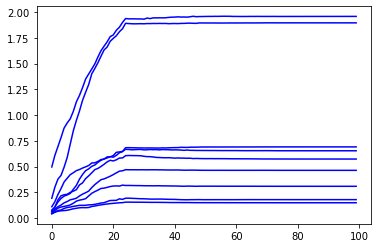

In [125]:
def weight_history_to_layer_max_magnitude_and_means(w_avg, include_batch_norm = True):
    weight_keys = [x for x in w_avg.keys() if ".0.weight" in x]
    if include_batch_norm:
        weight_keys += [x for x in w_avg.keys() if ".1.weight" in x]
    def max_magnitude(t):
        return torch.max(torch.abs(t))
    def mean_magnitude(t):
        return torch.mean(torch.abs(t))
    all_means = [mean_magnitude(w_avg[w]) for w in weight_keys]
    all_max = [max_magnitude(w_avg[w]) for w in weight_keys]
    return all_means, all_max
max_history = [weight_history_to_layer_max_magnitude_and_means(baseline.avg_weight_history[t], include_batch_norm = False) for t in range(100)]
max_history = [x[1] for x in max_history]
by_layer = [[max_history[k][l].cpu() for k in range(len(max_history))] for l in range(len(max_history[0]))]

[plt.plot([x for x in range(100)],by_layer[l],  '-k', color='blue') for l in range(9)]

In [126]:
# watcher

In [129]:
# max_history = [weight_history_to_layer_max_magnitude_and_means(watcher, include_batch_norm = False) for t in range(1)]
# max_history = [(x[1]) for x in max_history]
# by_layer = [[max_history[k][l].cpu() for k in range(len(max_history))] for l in range(len(max_history[0]))]

# [plt.plot([x for x in range(1)],by_layer[l],  '-k', color=['blue','red','green','blue', 'red', 'green', 'blue', 'red', 'green'][l]) for l in range(5,6)]

In [131]:
# max_history

In [ ]:
baseline = load_result("baseline.pickle")
sigmoid_against_noise_attack = run_federated_test(agg_fn = sigmoid_aggregation,                    
                                         rounds = 130, # go 30 pounds past where the baseline left off              
                                         local_epochs = 4,        # all else the same                     
                                         num_devices = 50,         
                                         device_pct = 0.2,          
                                         data_pct = 0.1,           
                                         net = ConvNet().to(mps),  
                                         evil_round = 110, # attack after 10 rounds more training with the new acc fn        
                                         attacker_strategy = big_noise_attack, # device 2 will carry out big noise attack  
                                         evil_device_id = 2,     
                                         evaluate_attack = None, # we will evaluate manually afterwards 
                                         output_filename = "sigmoid_against_noise_attack_final.pickle",
                                         resume_from_snap = baseline, #pick up where baseline left off  
                                         snapshot = True)  

In [ ]:
sca_zero_one = switch_classes_attack(0,1,25)
baseline = load_result("baseline.pickle")
switch_classes_no_defense = run_federated_test(                    
                                         rounds = 130, # go 30 pounds past where the baseline left off              
                                         local_epochs = 4,        # all else the same                     
                                         num_devices = 50,         
                                         device_pct = 0.2,          
                                         data_pct = 0.1,           
                                         net = ConvNet().to(mps),  
                                         evil_round = 110, # attack after 10 rounds more training with the new acc fn        
                                         attacker_strategy = sca_zero_one, # device 2 will carry out big noise attack  
                                         evil_device_id = 2,     
                                         evaluate_attack = None, # we will evaluate manually afterwards 
                                         output_filename = "switch_classes_no_defense_multiple_final.pickle",
                                         resume_from_snap = baseline, #pick up where baseline left off  
                                         snapshot = True, 
                                         multiple_attack_rounds = [100,101,102,103,104,105,106,107,108,109]) # 

In [ ]:
sca_zero_one_2 = switch_classes_attack(0,1,25)
baseline = load_result("baseline.pickle")
switch_classes_sigmoid_defense = run_federated_test(  agg_fn = sigmoid_aggregation, 
                                         rounds = 130, # go 30 pounds past where the baseline left off              
                                         local_epochs = 4,        # all else the same                     
                                         num_devices = 50,         
                                         device_pct = 0.2,          
                                         data_pct = 0.1,           
                                         net = ConvNet().to(mps),  
                                         evil_round = 110, # attack after 10 rounds more training with the new acc fn        
                                         attacker_strategy = sca_zero_one_2, # device 2 will carry out big noise attack  
                                         evil_device_id = 2,     
                                         evaluate_attack = None, # we will evaluate manually afterwards 
                                         output_filename = "switch_classes_sigmoid_defense_multiple_final.pickle",
                                         resume_from_snap = baseline, #pick up where baseline left off  
                                         snapshot = True, 
                                         multiple_attack_rounds = [100,101,102,103,104,105,106,107,108,109]) # 